In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model

In [2]:


# Définir le chemin des données
data_path = "malaria_hematie_dataset"
uninfected_dir = os.path.join(data_path, "Uninfected")
parasitized_dir = os.path.join(data_path, "Parasitized")

# Fonction pour charger les données
def load_data(data_dir):
    images = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            label = folder
            for file in os.listdir(folder_path):
                try:
                    image_path = os.path.join(folder_path, file)
                    image = Image.open(image_path).resize((64, 64))
                    images.append(np.array(image))
                    labels.append(label)
                except Exception as e:
                    print(f"Erreur dans la lecture de {image_path}: {str(e)}")
    return np.array(images) / 255.0, labels

# Charger les images et les étiquettes
images, labels = load_data(data_path)

# Encoder les étiquettes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Diviser les données en ensembles d'entraînement et de validation
train_images, val_images, train_labels, val_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Afficher des informations sur les données
print(f"Nombre d'images: {len(images)}")
print(f"Dimensions des images: {images.shape}")
print(f"Nombre de labels: {len(encoded_labels)}")


Nombre d'images: 27558
Dimensions des images: (27558, 64, 64, 3)
Nombre de labels: 27558


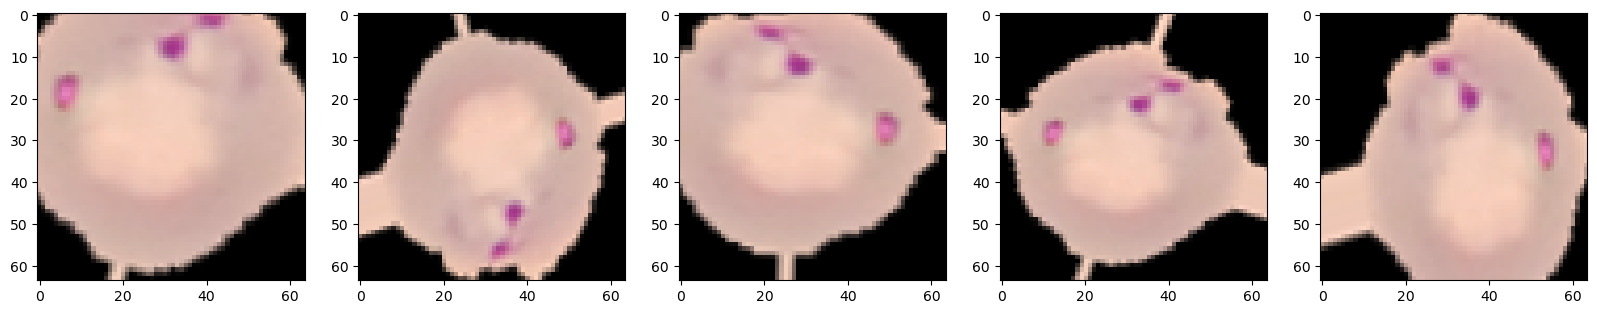

In [12]:
# Configurer l'augmentation des données
data_augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.15
)

# Visualiser quelques images augmentées
augmented_images = [data_augmentor.random_transform(train_images[0]) for _ in range(5)]
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for ax, image in zip(axes, augmented_images):
    ax.imshow(image)
plt.show()


In [4]:
# Définir des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-5)

# Définir les dimensions des images
IMAGE_HEIGHT, IMAGE_WIDTH, channels = train_images.shape[1:]

# Modèle basé sur VGG16 pré-entraîné
def create_model_vgg16():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, channels))
    for layer in vgg16_base.layers:
        layer.trainable = False
    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Modèle basé sur ResNet50 pré-entraîné
def create_model_resnet50():
    resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, channels))
    for layer in resnet50_base.layers:
        layer.trainable = False
    model = Sequential([
        resnet50_base,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
# Entraîner les modèles
batch_size = 32
epochs = 55

In [6]:
model = keras.Sequential(
  [
      # Feature learning ~ Encoder
      keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, channels)),
      keras.layers.Conv2D(64, kernel_size=(2, 2), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),

      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(64, kernel_size=(2, 2), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),

      keras.layers.Dropout(0.3),
      
      keras.layers.Conv2D(128, kernel_size=(2, 2), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),

      keras.layers.Dropout(0.3),

      # connexion encoder <-> classifier
      keras.layers.Flatten(),

      # Classifier ~ Fully connected
      keras.layers.Dense(1, activation='sigmoid')

  ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_decay]
    )

model.summary()



Epoch 1/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 79ms/step - accuracy: 0.6011 - loss: 0.6373 - val_accuracy: 0.9278 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 2/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.8994 - loss: 0.3069 - val_accuracy: 0.9305 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 3/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.9242 - loss: 0.2305 - val_accuracy: 0.9387 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 4/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9465 - loss: 0.1651 - val_accuracy: 0.9541 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 5/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9483 - loss: 0.1596 - val_accuracy: 0.9530 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 6/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9501 - loss: 0.1448 - val_accuracy: 0.9550 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 7/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.9497 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,109 (684.02 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,740 (456.02 KB)

In [9]:
model= create_model_vgg16()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_decay]
    )

model.save_weights(f'vgg16.weights.h5')

model = VGG16(weights="imagenet")
predictions = model.predict(image_preprocessed)


Epoch 1/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 339s 490ms/step - accuracy: 0.8513 - loss: 0.3376 - val_accuracy: 0.9265 - val_loss: 0.1854 - learning_rate: 0.0010
Epoch 2/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 347s 504ms/step - accuracy: 0.9198 - loss: 0.2116 - val_accuracy: 0.9325 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 3/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 334s 485ms/step - accuracy: 0.9263 - loss: 0.1932 - val_accuracy: 0.9347 - val_loss: 0.1699 - learning_rate: 0.0010


In [11]:


# Créer et compiler les modèles
model = create_model_resnet50()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_decay]
    )

# Sauvegarder les poids des modèles
model.save_weights(f'resnet.h5')


Epoch 1/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 329s 423ms/step - accuracy: 0.6084 - loss: 0.6683 - val_accuracy: 0.6676 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 2/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 285s 413ms/step - accuracy: 0.6572 - loss: 0.6247 - val_accuracy: 0.6740 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 3/55
689/689 ━━━━━━━━━━━━━━━━━━━━ 273s 395ms/step - accuracy: 0.6660 - loss: 0.6117 - val_accuracy: 0.6841 - val_loss: 0.5925 - learning_rate: 0.0010


ValueError: The filename must end in `.weights.h5`. Received: filepath=resnet.h5